In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

df = pd.read_csv("american_bankruptcy.csv")
df = df.drop(columns = ["company_name"])
df = df.drop(columns = ["year"])
print(df.head(10))

Mounted at /content/drive
  status_label       X1        X2      X3       X4       X5      X6       X7  \
0        alive  511.267   833.107  18.373   89.031  336.018  35.163  128.348   
1        alive  485.856   713.811  18.577   64.367  320.590  18.531  115.187   
2        alive  436.656   526.477  22.496   27.207  286.588 -58.939   77.528   
3        alive  396.412   496.747  27.172   30.745  259.954 -12.410   66.322   
4        alive  432.204   523.302  26.680   47.491  247.245   3.504  104.661   
5        alive  474.542   598.172  27.950   61.774  255.477  15.453  127.121   
6        alive  624.454   704.081  29.222   91.877  323.592  35.163  136.272   
7        alive  645.721   837.171  32.199  118.907  342.593  58.660  181.691   
8        alive  783.431  1080.895  39.952  168.522  435.608  75.144  202.472   
9        alive  851.312  1110.677  40.551  166.080  477.424  78.651  227.300   

          X8        X9       X10      X11      X12      X13      X14      X15  \
0   372.7519

In [ ]:
# 1. DATA PREPROCESSING

# Data Cleaning

missing_values = df.isnull().sum()
print("\nMissing values per column:\n", missing_values)
duplicates = df.duplicated().sum()
print("\nDuplicates in the dataset:", duplicates)


Missing values per column:
 status_label    0
X1              0
X2              0
X3              0
X4              0
X5              0
X6              0
X7              0
X8              0
X9              0
X10             0
X11             0
X12             0
X13             0
X14             0
X15             0
X16             0
X17             0
X18             0
dtype: int64

Duplicates in the dataset: 0


In [ ]:
print("\nLabels in the dataset:", df["status_label"].unique())
df["status_encoding"] = df["status_label"].map({"alive": 0, "failed": 1})
df["status_encoding"] = df["status_encoding"].astype(int)
df = df.drop(columns = ["status_label"])
print(df.head(10))


Labels in the dataset: ['alive' 'failed']
        X1        X2      X3       X4       X5      X6       X7         X8  \
0  511.267   833.107  18.373   89.031  336.018  35.163  128.348   372.7519   
1  485.856   713.811  18.577   64.367  320.590  18.531  115.187   377.1180   
2  436.656   526.477  22.496   27.207  286.588 -58.939   77.528   364.5928   
3  396.412   496.747  27.172   30.745  259.954 -12.410   66.322   143.3295   
4  432.204   523.302  26.680   47.491  247.245   3.504  104.661   308.9071   
5  474.542   598.172  27.950   61.774  255.477  15.453  127.121   522.6794   
6  624.454   704.081  29.222   91.877  323.592  35.163  136.272   882.6283   
7  645.721   837.171  32.199  118.907  342.593  58.660  181.691  1226.1925   
8  783.431  1080.895  39.952  168.522  435.608  75.144  202.472   747.5434   
9  851.312  1110.677  40.551  166.080  477.424  78.651  227.300   571.5948   

         X9       X10      X11      X12      X13      X14      X15       X16  \
0  1024.333   740.

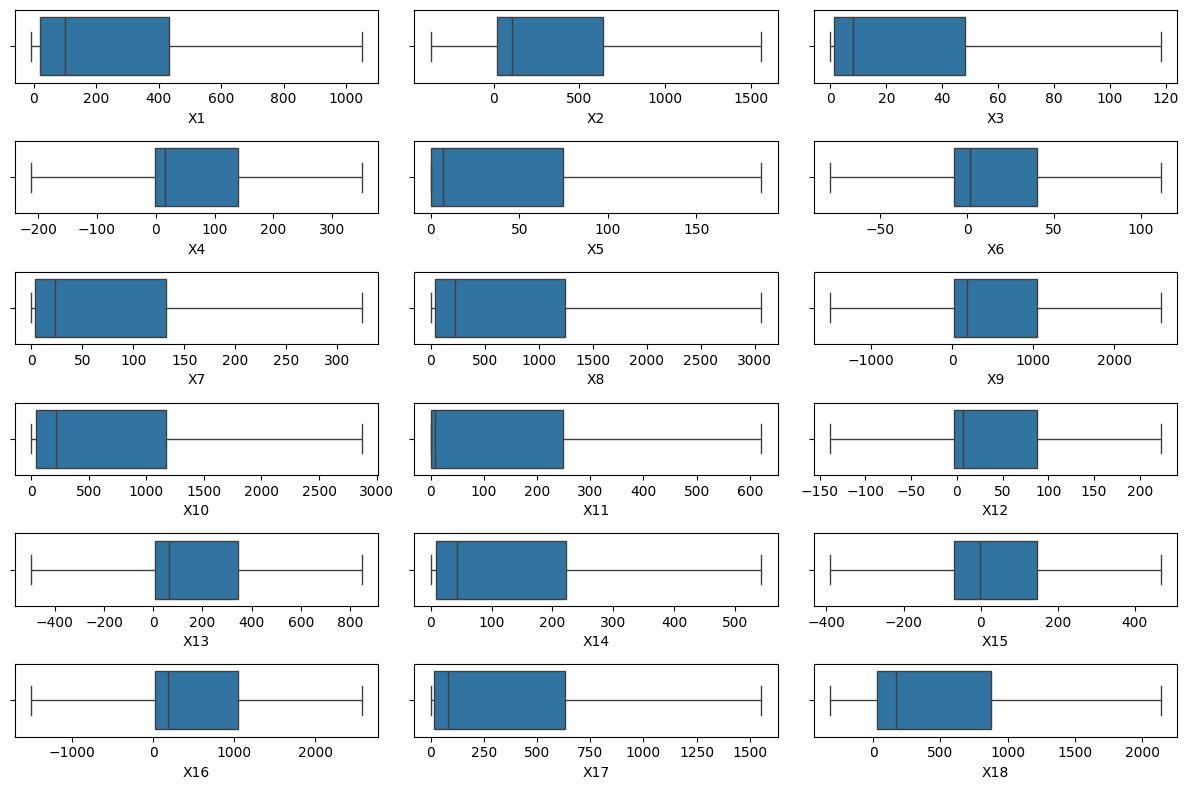

In [2]:
features_to_plot = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10','X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']

for feature in features_to_plot:
  Q1 = df[feature].quantile(0.25)
  Q2 = df[feature].quantile(0.50)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3- Q1
  lowerBound = Q1 - 1.5 * IQR
  upperBound = Q3 + 1.5 * IQR

  #outliersLow = df[(df[feature] < lowerBound)][feature]
  #outliersUp = df[(df[feature] > upperBound)][feature]
  df[feature] = df[feature].clip(lower=lowerBound, upper=upperBound)


plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_plot, 1):
  plt.subplot(6, 3, i)
  sns.boxplot(x=df[feature])

plt.tight_layout()
plt.show()

         X1        X2        X3        X4        X5        X6        X7  \
0 -0.098432 -0.094175 -0.149182 -0.122282  0.116192 -0.070151 -0.111058   
1  0.398392  0.304415  1.154211  0.896891  0.441446  0.249240  0.705604   
2 -0.163236 -0.130137 -0.172887 -0.159123 -0.036532 -0.079020 -0.214429   
3  0.823411  3.293836  1.539412  0.883689  2.220233  0.352544  0.457781   
4 -0.209286 -0.167993 -0.164052 -0.168249 -0.183554 -0.092823 -0.185685   
5 -0.098329  0.012442  0.208926  0.162574 -0.173036  0.081153  0.011554   
6 -0.143813 -0.068305  0.088031 -0.021313 -0.177570 -0.208893 -0.123791   
7 -0.098241 -0.151461 -0.144036 -0.371891 -0.191012 -0.395013 -0.191498   
8 -0.205775 -0.171854 -0.144194 -0.167007 -0.190249 -0.093003 -0.200911   
9 -0.208939 -0.172719 -0.149816 -0.174012 -0.191012 -0.195659 -0.196339   

         X8        X9       X10       X11       X12       X13       X14  \
0 -0.129712 -0.105293 -0.160393 -0.221582 -0.099594 -0.110748 -0.110575   
1  0.534685  0.347587  1

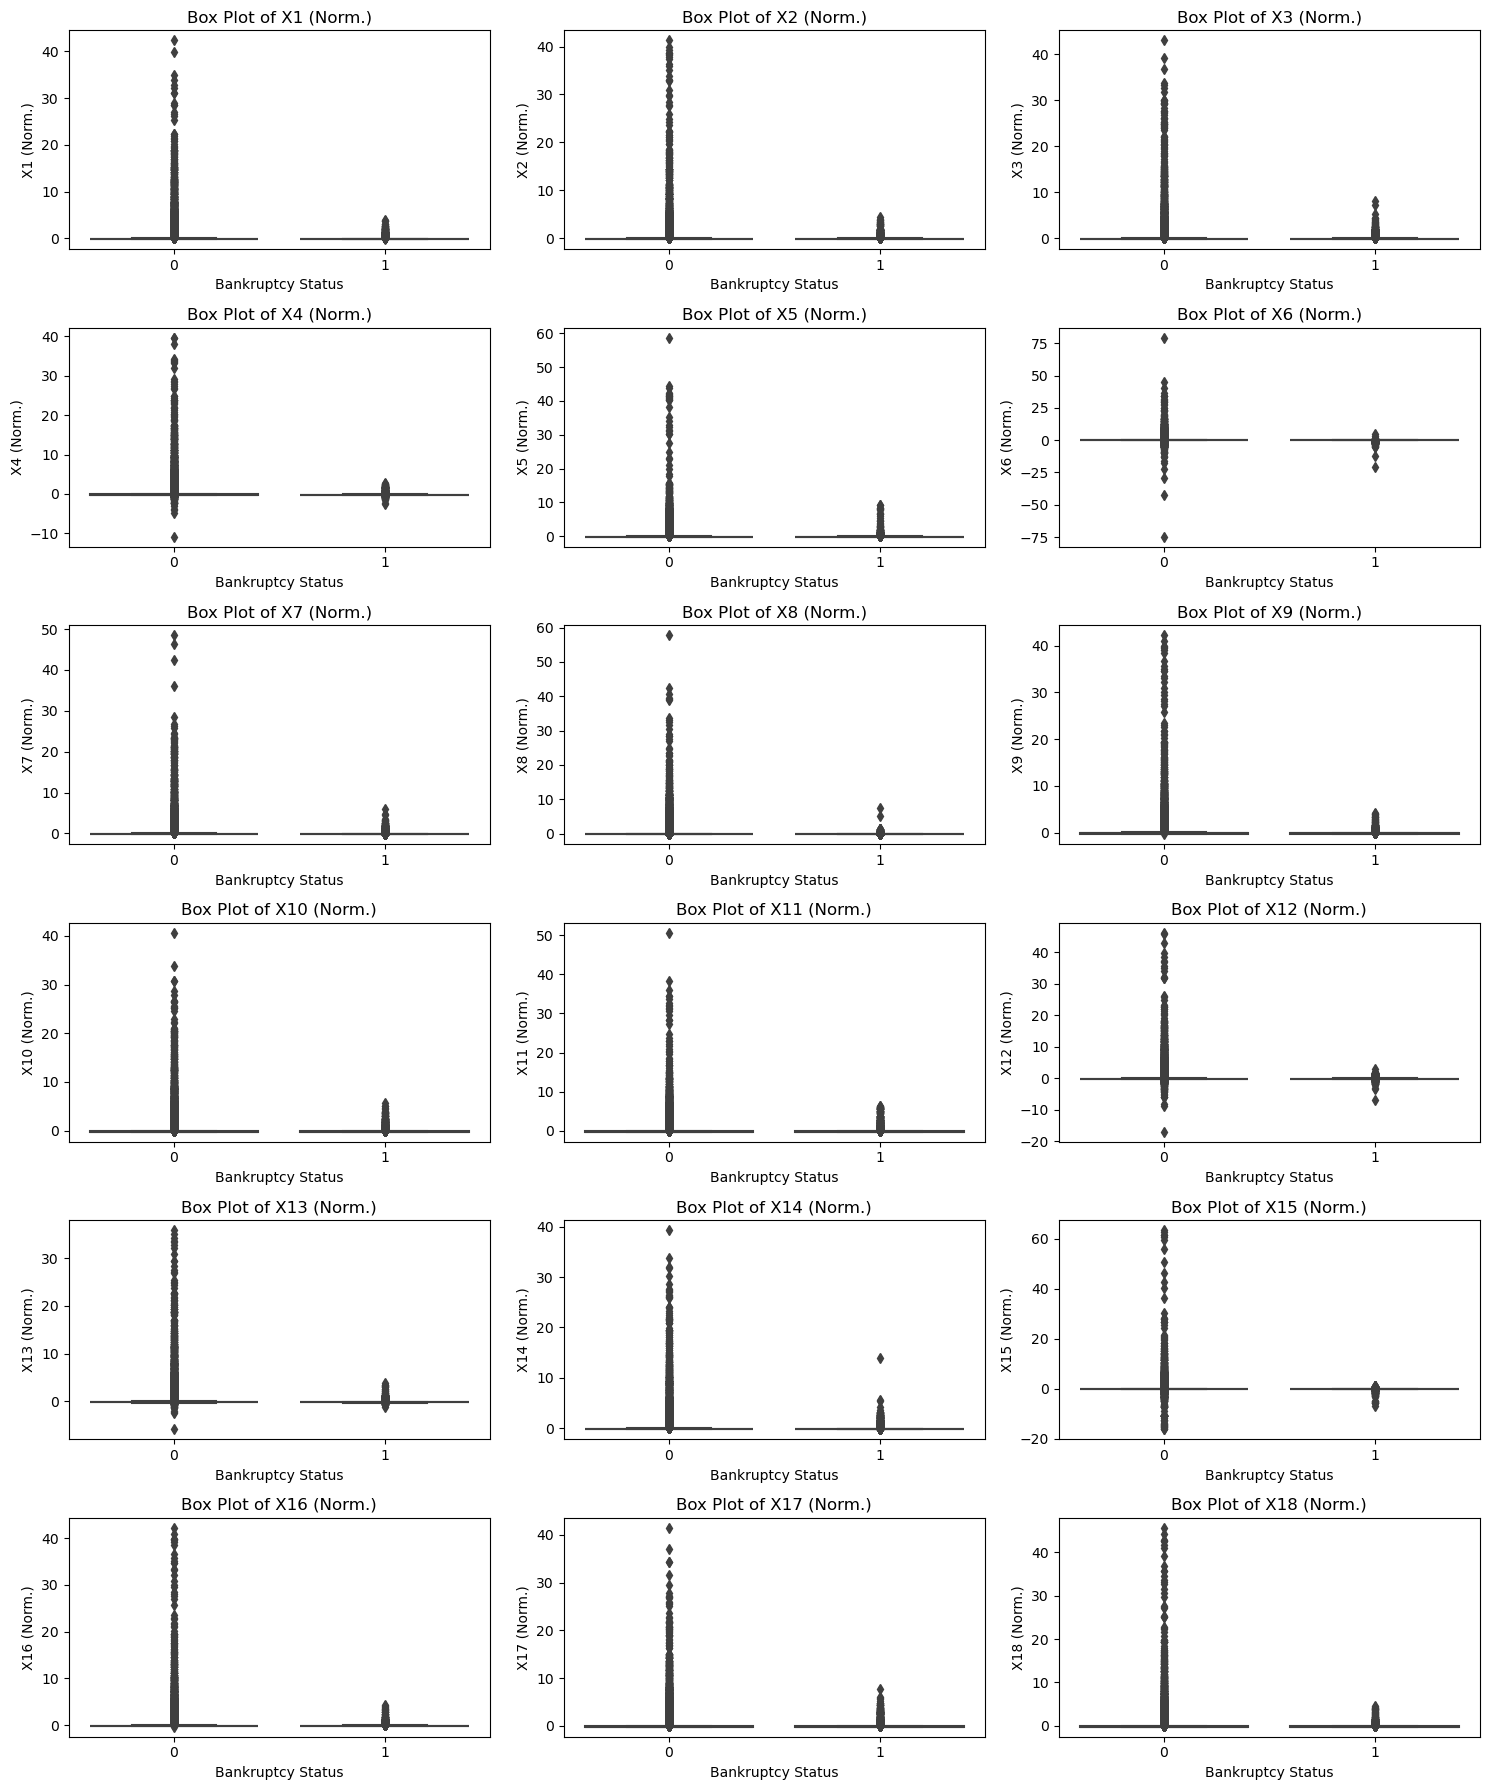

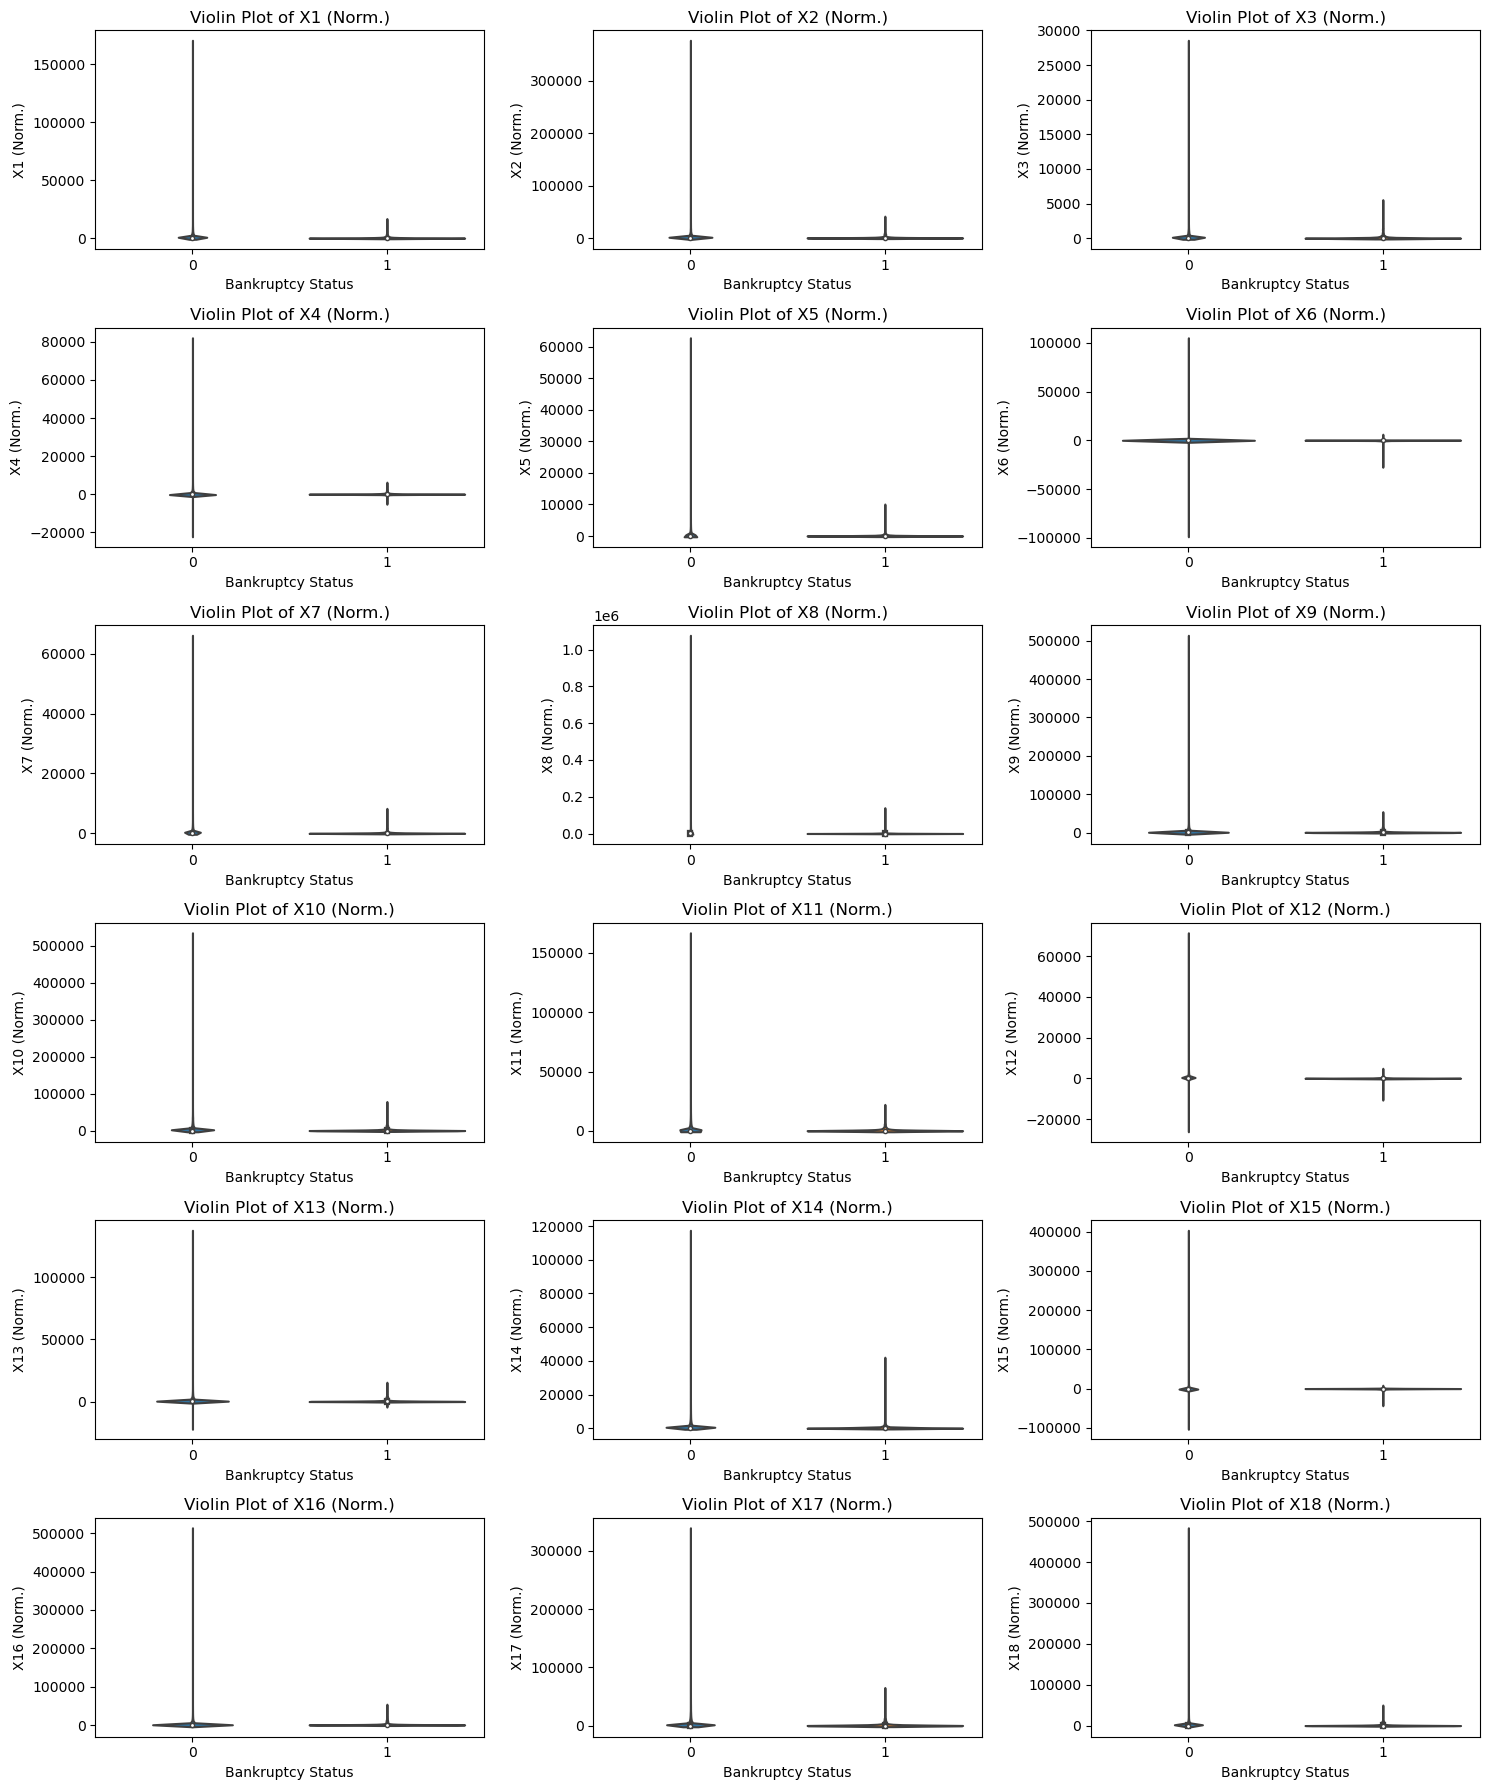

In [ ]:
# Data Scaling/Standardization

scaler = StandardScaler()

X = df.iloc[:, :-1]
y = df["status_encoding"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = 0.20, shuffle = True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_scaled = pd.concat([pd.DataFrame(X_train_scaled, columns = X.columns), pd.DataFrame(y_train.reset_index(drop = True), columns = ["status_encoding"])], axis = 1)
test_scaled = pd.concat([pd.DataFrame(X_test_scaled, columns = X.columns), pd.DataFrame(y_test.reset_index(drop = True), columns = ["status_encoding"])], axis = 1)
df_scaled = pd.concat([train_scaled, test_scaled], axis = 0)
print(df_scaled.head(10))

fig, axes = plt.subplots(6, 3, figsize = (15, 18))
i = 0
j = 0

for column in df_scaled.columns[:-1]:
    sns.boxplot(x = "status_encoding", y = column, data = df_scaled, ax = axes[i, j])
    axes[i, j].set_title(f"Box Plot of {column} (Norm.)")
    axes[i, j].set_xlabel("Bankruptcy Status")
    axes[i, j].set_ylabel(f"{column} (Norm.)")
    j += 1
    if j == 3:
        i += 1
        j = 0
plt.tight_layout()
plt.show()

print("\n\n\n\n")

fig, axes = plt.subplots(6, 3, figsize = (15, 18))
i = 0
j = 0
for column in df_scaled.columns[:-1]:
    sns.violinplot(x = "status_encoding", y = column, data = df, ax = axes[i, j])
    axes[i, j].set_title(f"Violin Plot of {column} (Norm.)")
    axes[i, j].set_xlabel("Bankruptcy Status")
    axes[i, j].set_ylabel(f"{column} (Norm.)")
    j += 1
    if j == 3:
        i += 1
        j = 0
plt.tight_layout()
plt.show()